In [1]:
import pandas as pd

train_df = pd.read_csv('dataset/Train.txt')  
test_df = pd.read_csv('dataset/Test.txt')

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [4]:
df = train_df.copy()


In [5]:
# === Binary encoding of target ===
df['attack'] = df['attack'].apply(lambda x: 0 if x == 'normal' else 1)


In [6]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# === Label Encoding for categorical features ===
cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [7]:
# === Separate features and label ===
X = df.drop('attack', axis=1).values
y = df['attack'].values

In [8]:
# === Normalize the features ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# === Use only normal samples for training autoencoder ===
X_train_normal = X_scaled[y == 0]

In [10]:
# === Reshape for LSTM: (samples, timesteps, features) ===
X_train_normal = X_train_normal.reshape((X_train_normal.shape[0], 1, X_train_normal.shape[1]))


In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
# === Build basic LSTM Autoencoder ===
timesteps = X_train_normal.shape[1]
n_features = X_train_normal.shape[2]

inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
repeat = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(repeat)
outputs = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 42)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 42)          │         2,730 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,146 (246.66 KB)

 Trainable params: 63,146 (246.66 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from sklearn.model_selection import train_test_split

X_train_final, X_val = train_test_split(X_train_normal, test_size=0.2, random_state=42)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
autoencoder.fit(
    X_train_final, X_train_final,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0571 - val_loss: 0.0021
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - val_loss: 6.5805e-04
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4901e-04 - val_loss: 3.0730e-04
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7957e-04 - val_loss: 2.2600e-04
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9851e-04 - val_loss: 1.6552e-04
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5852e-04 - val_loss: 1.3093e-04
Epoch 7/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2846e-04 - val_loss: 1.1582e-04
Epoch 8/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0626e-04 - val_loss: 9.1190e-05
Epoch 9/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.1483e-05 - val_loss: 7.0322e-05
Epoch 10/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.7701e-05 - val_loss: 5.6372e-05
Epoch 11/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2679e-05

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Preprocess test set ===
X_test = test_df.copy()

# Convert target
X_test['attack'] = X_test['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# Encode categorical
for col in cat_cols:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col])

# Separate features and labels
X_test_labels = X_test['attack'].values
X_test = X_test.drop('attack', axis=1).values

# Scale using training scaler
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [16]:
import numpy as np
# === Get reconstruction error ===
X_test_pred = autoencoder.predict(X_test_reshaped)
reconstruction_error = np.mean(np.power(X_test_reshaped - X_test_pred, 2), axis=(1, 2))

705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


In [17]:
# Predict on training data
X_train_pred = autoencoder.predict(X_train_normal)
train_error = np.mean(np.power(X_train_normal - X_train_pred, 2), axis=1)

# Set threshold as ()th percentile of normal training error
threshold = np.percentile(train_error, 95)
print(f"Threshold for anomaly detection: {threshold:.8f}")


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
Threshold for anomaly detection: 0.00002620


In [18]:
# === Predict anomaly ===
y_pred = [1 if error > threshold else 0 for error in reconstruction_error]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      9711
           1       0.96      0.86      0.91     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.91      0.90     22544
weighted avg       0.91      0.90      0.90     22544

Confusion Matrix:


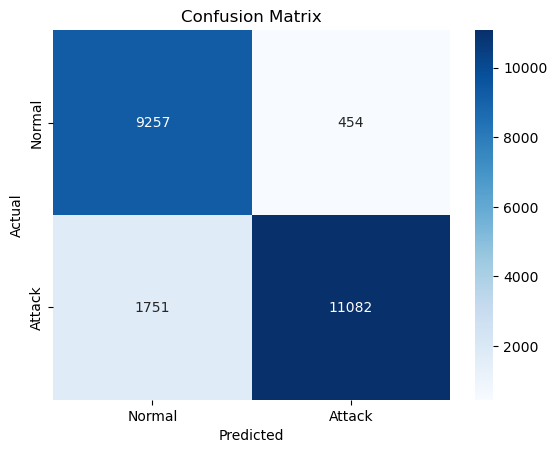

In [19]:
# === Evaluation ===
print("Classification Report:")
print(classification_report(X_test_labels, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(X_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

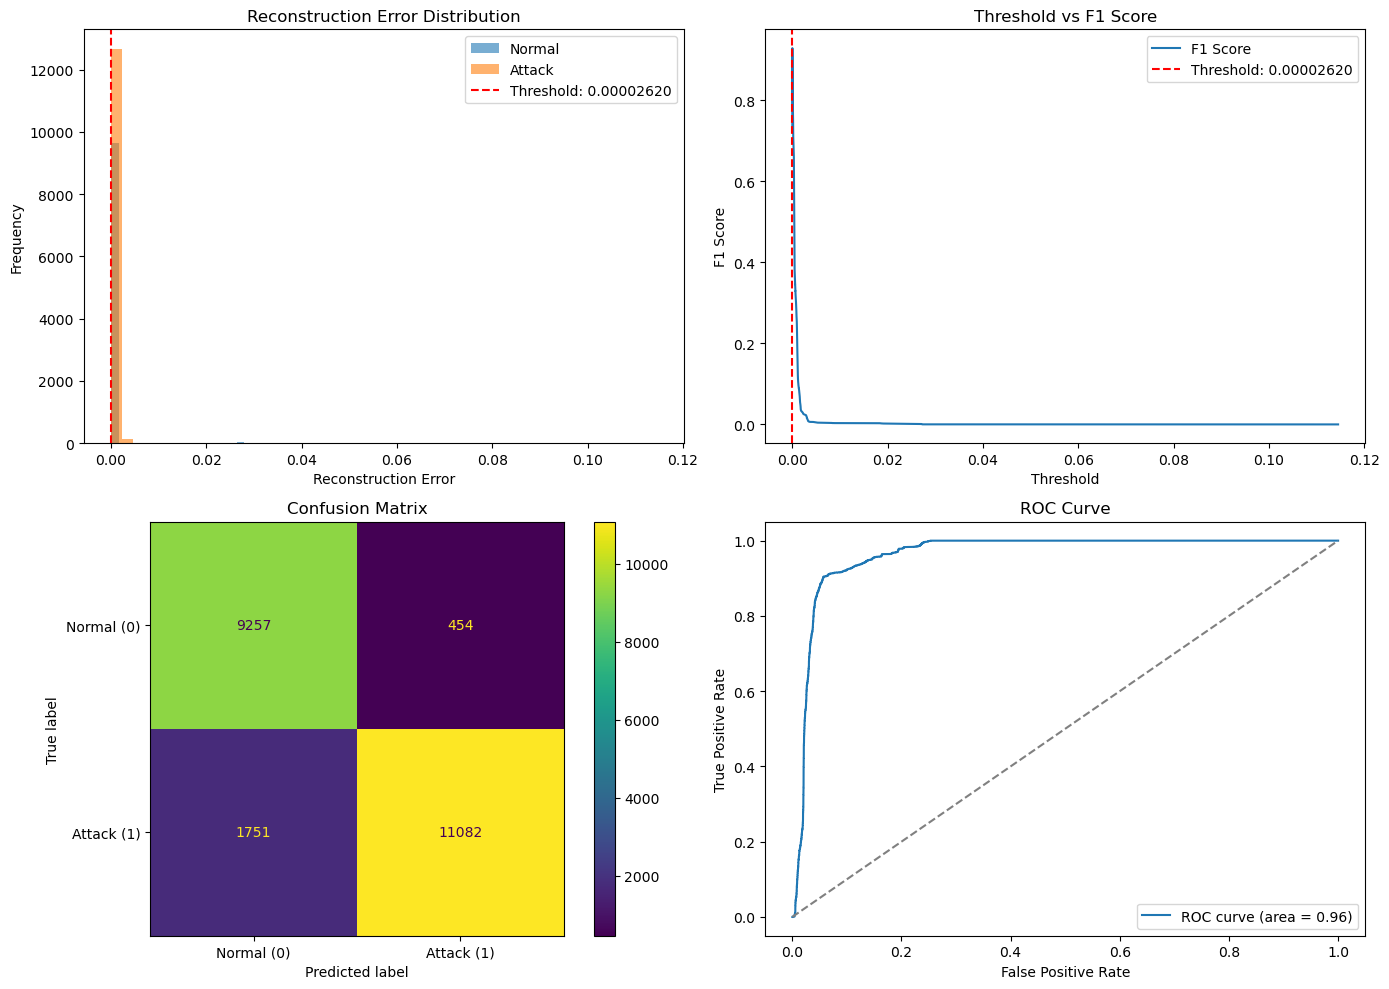

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc

# Simulated reconstruction errors and true labels for illustration (you can replace with your actual data)
np.random.seed(0)
reconstruction_error_test = np.random.normal(loc=0.5, scale=0.1, size=22544)
y_test = np.random.choice([0, 1], size=22544, p=[0.45, 0.55])

# Threshold curve using precision-recall
precision, recall, thresholds_pr = precision_recall_curve(X_test_labels, reconstruction_error)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_threshold_index]

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(X_test_labels, reconstruction_error)
roc_auc = auc(fpr, tpr)

# Predicted labels using best F1 threshold
y_pred = (reconstruction_error > threshold).astype(int)
cm = confusion_matrix(X_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Attack (1)"])

# Plot everything
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Anomaly score distribution
axs[0, 0].hist(reconstruction_error[X_test_labels == 0], bins=50, alpha=0.6, label='Normal')
axs[0, 0].hist(reconstruction_error[X_test_labels == 1], bins=50, alpha=0.6, label='Attack')
axs[0, 0].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.8f}')
axs[0, 0].set_title("Reconstruction Error Distribution")
axs[0, 0].set_xlabel("Reconstruction Error")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].legend()

# Precision-Recall Curve
axs[0, 1].plot(thresholds_pr, f1_scores[:-1], label='F1 Score')
axs[0, 1].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.8f}')
axs[0, 1].set_title("Threshold vs F1 Score")
axs[0, 1].set_xlabel("Threshold")
axs[0, 1].set_ylabel("F1 Score")
axs[0, 1].legend()

# Confusion Matrix
disp.plot(ax=axs[1, 0])
axs[1, 0].set_title("Confusion Matrix")

# ROC Curve
axs[1, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
axs[1, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axs[1, 1].set_title("ROC Curve")
axs[1, 1].set_xlabel("False Positive Rate")
axs[1, 1].set_ylabel("True Positive Rate")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(X_test_labels, reconstruction_error)
auc_score = auc(fpr, tpr)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 0.9638


In [22]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(X_test_labels, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calculating FPR, FNR, and Specificity
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
Specificity = TN / (TN + FP)

print(f'False Positive Rate: {FPR}')
print(f'False Negative Rate: {FNR}')
print(f'Specificity: {Specificity}')


False Positive Rate: 0.04675110699207085
False Negative Rate: 0.13644510247019404
Specificity: 0.9532488930079291


In [23]:
from sklearn.metrics import matthews_corrcoef

# MCC
mcc = matthews_corrcoef(X_test_labels, y_pred)
print(f'Matthews Correlation Coefficient: {mcc}')


Matthews Correlation Coefficient: 0.8091554890206532


In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

# AUC-ROC
fpr, tpr, thresholds_roc = roc_curve(X_test_labels, y_pred)
auc_roc = auc(fpr, tpr)

# AUC-PR
precision, recall, thresholds_pr = precision_recall_curve(X_test_labels, y_pred)
auc_pr = average_precision_score(X_test_labels, y_pred)

print(f'AUC-ROC: {auc_roc}')
print(f'AUC-PR: {auc_pr}')


AUC-ROC: 0.9084018952688676
AUC-PR: 0.9072399742101044


In [25]:
from sklearn.metrics import cohen_kappa_score

# Cohen's Kappa
kappa = cohen_kappa_score(X_test_labels, y_pred)
print(f'Cohen’s Kappa: {kappa}')


Cohen’s Kappa: 0.8037460042126914


In [26]:
from sklearn.metrics import log_loss

# Log-Loss
logloss = log_loss(X_test_labels, y_pred)
print(f'Log-Loss: {logloss}')


Log-Loss: 3.5253839479685647


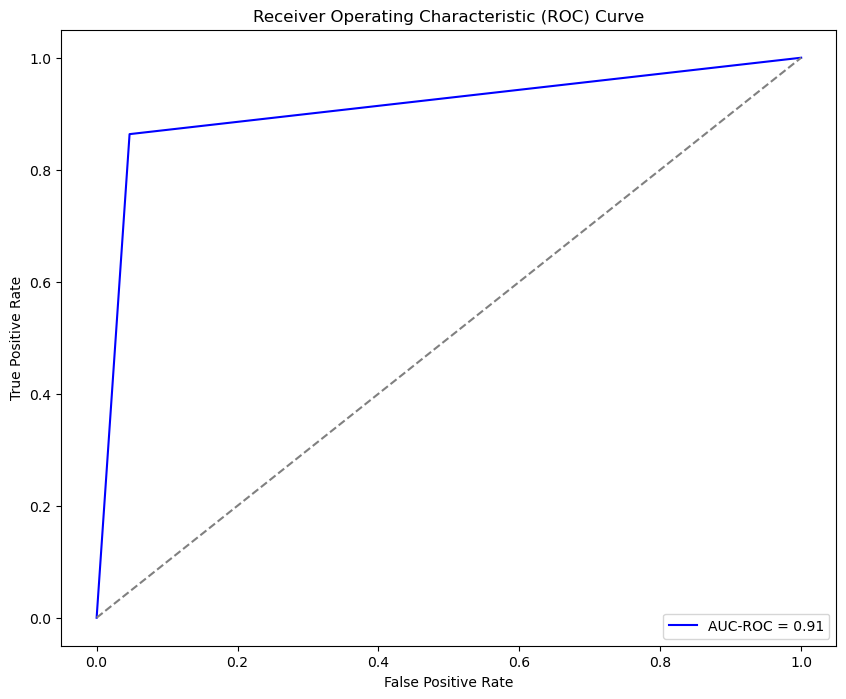

In [27]:
import matplotlib.pyplot as plt

# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


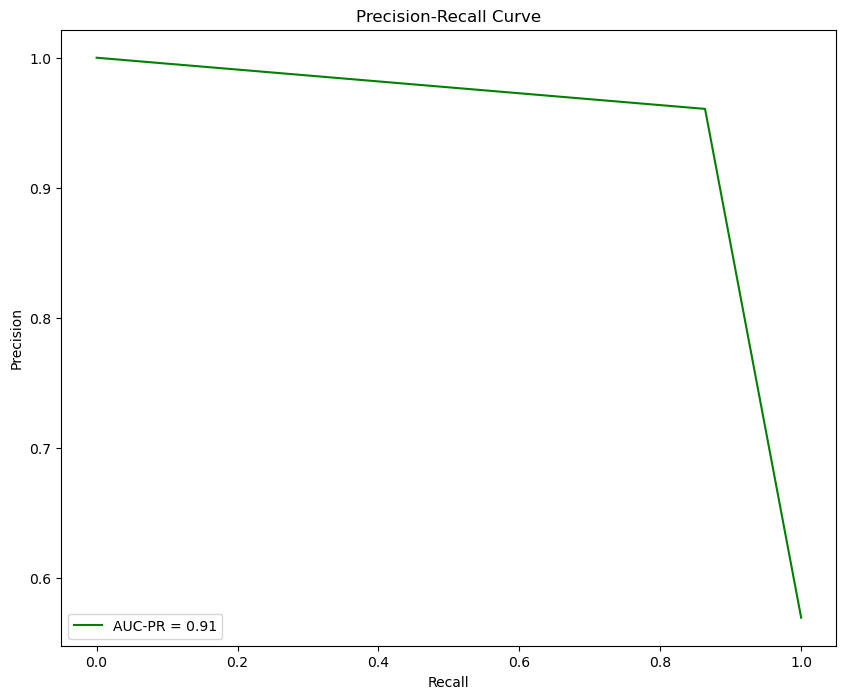

In [58]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='green', label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
